# Wspd Arima

https://leedakyeong.tistory.com/entry/Python-%EB%82%A0%EC%94%A8-%EC%8B%9C%EA%B3%84%EC%97%B4-%EB%8D%B0%EC%9D%B4%ED%84%B0Kaggle%EB%A1%9C-ARIMA-%EC%A0%81%EC%9A%A9%ED%95%98%EA%B8%B0

참조

In [12]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from glob import glob
import sys


if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.10.2  Device :  cuda


In [13]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.arima.model import ARIMA

In [14]:
plt.style.use('ggplot')

In [20]:
train_data = pd.read_csv("data/train_data.csv")
sample_submission = pd.read_csv("data/sample_submission.csv")

In [21]:
# train_data의 결측값 확인
train_data.isnull().sum()

TurbID         0
Day            0
Tmstamp        0
Wspd       45587
Wdir       45587
Etmp       45587
Itmp       45587
Ndir       45587
Pab1       45587
Pab2       45587
Pab3       45587
Prtv       45587
Patv       45587
dtype: int64

In [22]:
# method : 결측값을 변경할 방식입니다. bfill로 할경우 결측값을 바로 아래 값과 동일하게 변경합니다.
# 결측값 처리
train_data = train_data.fillna(method = 'bfill')

print(train_data.isnull().sum())

TurbID     0
Day        0
Tmstamp    0
Wspd       0
Wdir       0
Etmp       0
Itmp       0
Ndir       0
Pab1       0
Pab2       0
Pab3       0
Prtv       0
Patv       0
dtype: int64


In [23]:
train_data = train_data[train_data['TurbID']==21]

In [19]:
train_data = train_data[['Day','Tmstamp','Wspd']]

In [9]:
train_data.head()

,Day,Tmstamp,Wspd
576000,1,00:00,5.46
576001,1,00:10,5.46
576002,1,00:20,5.11
576003,1,00:30,4.80
576004,1,00:40,4.74


In [10]:
train_data.shape

(28800, 3)

In [11]:
train_data

,Day,Tmstamp,Wspd
576000,1,00:00,5.46
576001,1,00:10,5.46
576002,1,00:20,5.11
576003,1,00:30,4.80
576004,1,00:40,4.74
...,...,...,...
604795,200,23:10,4.05
604796,200,23:20,4.66
604797,200,23:30,4.26
604798,200,23:40,3.32


In [73]:
from datetime import datetime
from datetime import timedelta
dt = datetime(2020, 12, 31,23,50)
Days= []
for i in range(28800): 
    dt = dt + timedelta(minutes=10)
    dd=dt.strftime("%Y-%m-%d %H:%M")
    Days.append(dd)

In [74]:
train_data['Day']=Days

In [75]:
train_data.columns=['ds',"Tmstamp","Wspd"]

In [76]:
train_data

,ds,Tmstamp,Wspd
576000,2021-01-01 00:00,00:00,5.46
576001,2021-01-01 00:10,00:10,5.46
576002,2021-01-01 00:20,00:20,5.11
576003,2021-01-01 00:30,00:30,4.80
576004,2021-01-01 00:40,00:40,4.74
...,...,...,...
604795,2021-07-19 23:10,23:10,4.05
604796,2021-07-19 23:20,23:20,4.66
604797,2021-07-19 23:30,23:30,4.26
604798,2021-07-19 23:40,23:40,3.32


In [77]:
train_data['ds']=pd.to_datetime(train_data['ds'])

In [78]:
train_data.index = train_data.ds

In [79]:
train_data.drop(['Tmstamp','ds'],axis=1,inplace=True)

In [80]:
train_data.head()

,Wspd
ds,
2021-01-01 00:00:00,5.46
2021-01-01 00:10:00,5.46
2021-01-01 00:20:00,5.11
2021-01-01 00:30:00,4.80
2021-01-01 00:40:00,4.74


In [82]:
train_data.tail()

,Wspd
ds,
2021-07-19 23:10:00,4.05
2021-07-19 23:20:00,4.66
2021-07-19 23:30:00,4.26
2021-07-19 23:40:00,3.32
2021-07-19 23:50:00,3.22


# 시계열 분해

In [85]:
train_data.index

DatetimeIndex(['2021-01-01 00:00:00', '2021-01-01 00:10:00',
               '2021-01-01 00:20:00', '2021-01-01 00:30:00',
               '2021-01-01 00:40:00', '2021-01-01 00:50:00',
               '2021-01-01 01:00:00', '2021-01-01 01:10:00',
               '2021-01-01 01:20:00', '2021-01-01 01:30:00',
               ...
               '2021-07-19 22:20:00', '2021-07-19 22:30:00',
               '2021-07-19 22:40:00', '2021-07-19 22:50:00',
               '2021-07-19 23:00:00', '2021-07-19 23:10:00',
               '2021-07-19 23:20:00', '2021-07-19 23:30:00',
               '2021-07-19 23:40:00', '2021-07-19 23:50:00'],
              dtype='datetime64[ns]', name='ds', length=28800, freq=None)

Text(0, 0.5, 'Wspd')

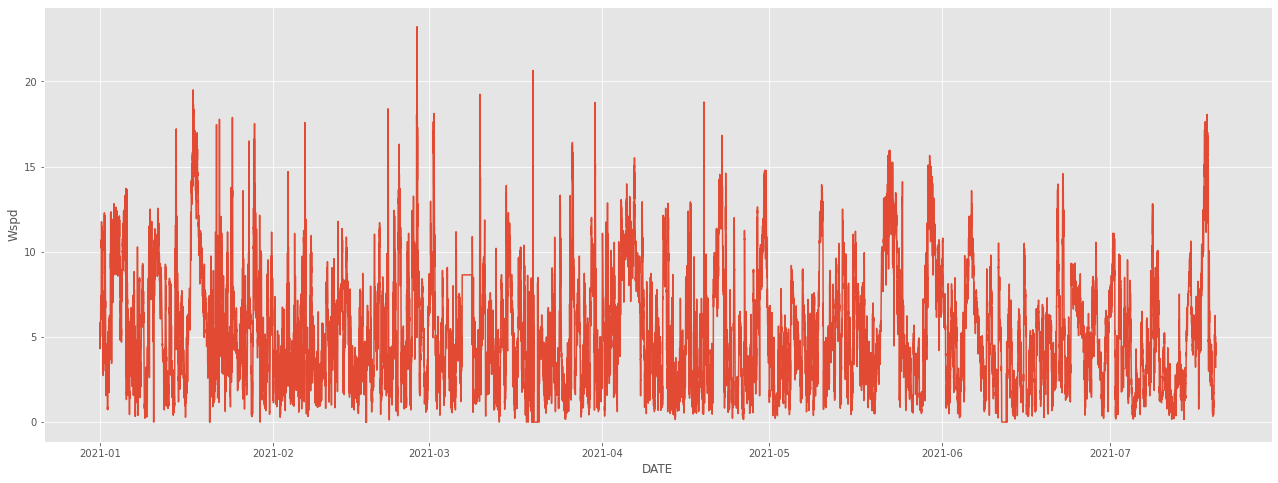

In [90]:
plt.figure(figsize=(22,8))
plt.plot(train_data.index, train_data.Wspd)
plt.xlabel("DATE")
plt.ylabel("Wspd")

#for i in np.arange(0,28800,288):
#    plt.vlines(train_data.index[i], 0, 20, color='gray', linestyle='solid', linewidth=3)


시간에따라 변하는 것은 없어보인다. 정상 시계열 처럼 보인다.

하지만, 1주일 정도의 주기는 있어 보인다.

<Figure size 432x288 with 0 Axes>

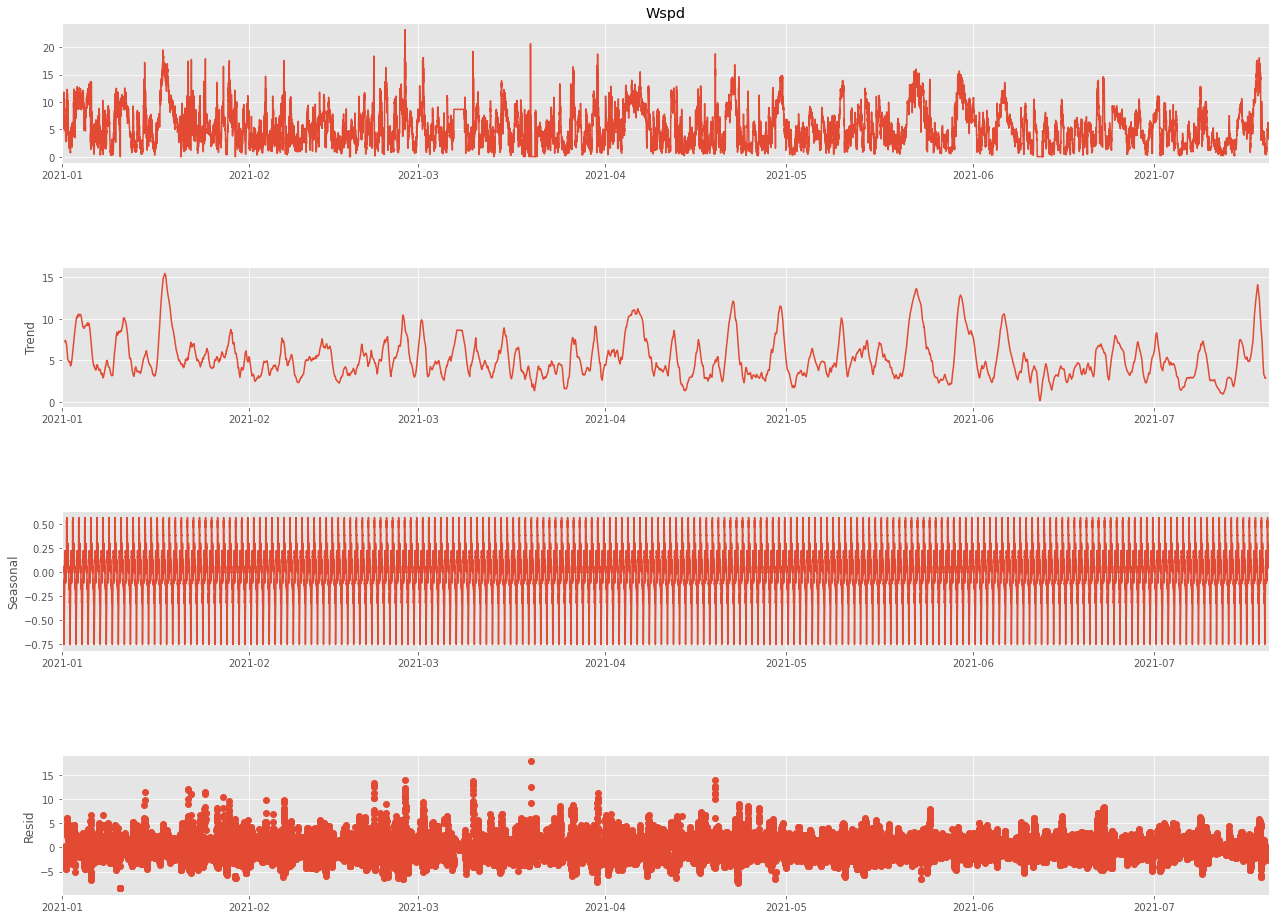

In [117]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train_data['Wspd'],model='additive',period=144)


fig = plt.figure()
fig = result.plot()
fig.set_size_inches(20,15)

# acf, pacf

비정상성을 제거하는 모델 ARIMA

- p : AR이 몇번째 까지 과거를 보는지
- d : 차분에 대한 파라미터
- q:  MR이 몇번째 과거까지 보는지


https://hongl.tistory.com/98

https://happy-chipmunk.tistory.com/entry/%EC%8B%9C%EA%B3%84%EC%97%B4-%EB%B6%84%EC%84%9D-%EB%8D%B0%EC%9D%B4%ED%84%B0-Stationarity-check-%ED%8C%8C%EC%9D%B4%EC%8D%AC%EC%9C%BC%EB%A1%9C-%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%9D%98-%EA%B3%84%EC%A0%88%EC%84%B1%EC%A3%BC%EA%B8%B0%EC%84%B1-%ED%8C%8C%EC%95%85%ED%95%98%EA%B8%B0-1-ACF-PACF-%ED%94%8C%EB%A1%AF-%EA%B7%B8%EB%A6%AC%EA%B3%A0-%ED%95%B4%EC%84%9D%ED%95%98%EA%B8%B0

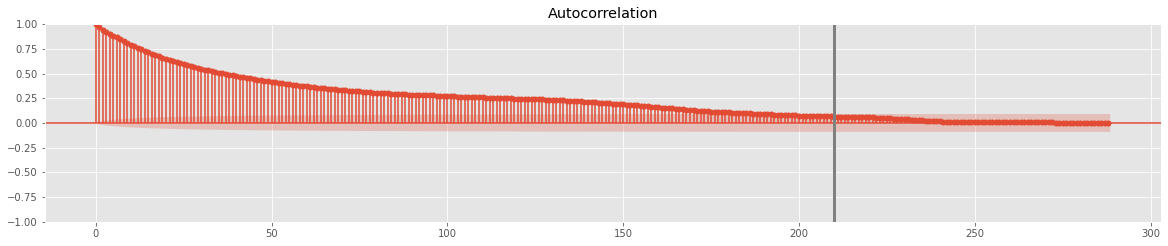

In [92]:

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(train_data['Wspd'],lags=288,ax=ax1)
plt.vlines(210, -1.0, 1.0, color='gray', linestyle='solid', linewidth=3)


0보다 크게 떨어지니, 정상성 만족 x.  데이터에 패턴이 존재한다고 할 수 있다.

q = 210으로 선정

In [93]:
result = adfuller(train_data['Wspd'],autolag=None,maxlag=144*2)
print("ADF Statistics : {}".format(result[0]))
print("p-value : {}".format(result[1]))



ADF Statistics : -8.221995765482426
p-value : 6.392736151221482e-13


ADF TEST는 통과한다. 
하지만, 0으로 수렴하는 과정이 매우 느리다.

In [94]:
def kpss_test(df):
    statistic, p_value,n_lags, critical_values = kpss(df)
    
    print("KPSS Statistic : {}".format(statistic))
    print("p-value : {}".format(p_value))
    print("num lags : {}".format(n_lags))
kpss_test(train_data['Wspd'])


KPSS Statistic : 0.45572052303659993
p-value : 0.05313770558767245
num lags : 96


kpss test 귀무가설을 기각하지 못하니, 안정적이라 할 수 있지만.

거의 0.05에 가깝다.

로그 변환은 하지 않는것이 좋다. -> 오히려 기각됨.

In [95]:
kpss_test(train_data['Wspd'])

KPSS Statistic : 0.45572052303659993
p-value : 0.05313770558767245
num lags : 96


C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


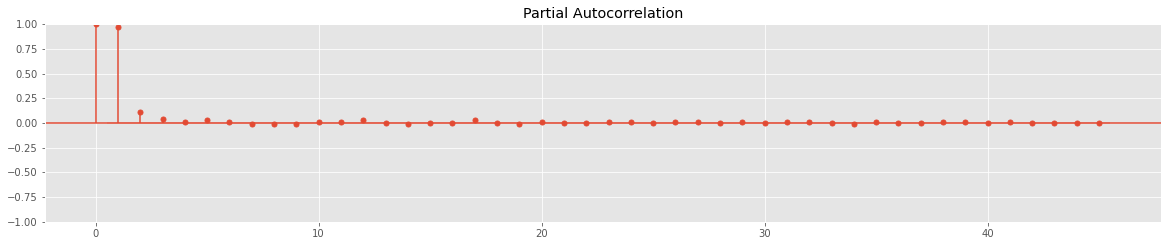

In [96]:

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = plot_pacf(train_data['Wspd'],ax=ax1)

P=2

현재는 AR(2) 모델이 가장 적합할 것으로 보인다.

# ARIMA

In [131]:
train_data_reduced = train_data.copy()

In [132]:
train_data_reduced=train_data_reduced.iloc[:-288,:]

In [133]:
model = ARIMA(train_data_reduced['Wspd'],order=(2,0,0),freq='10T')
model_fit = model.fit()

C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)


In [134]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   Wspd   No. Observations:                28512
Model:                 ARIMA(0, 0, 2)   Log Likelihood              -52609.848
Date:                Sun, 10 Jul 2022   AIC                         105227.695
Time:                        21:25:14   BIC                         105260.728
Sample:                    01-01-2021   HQIC                        105238.320
                         - 07-17-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2537      0.027    191.454      0.000       5.200       5.308
ma.L1          1.1225      0.003    361.782      0.000       1.116       1.129
ma.L2          0.6317      0.003    208.291      0.0

C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 50676 (\N{HANGUL SYLLABLE YEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from c

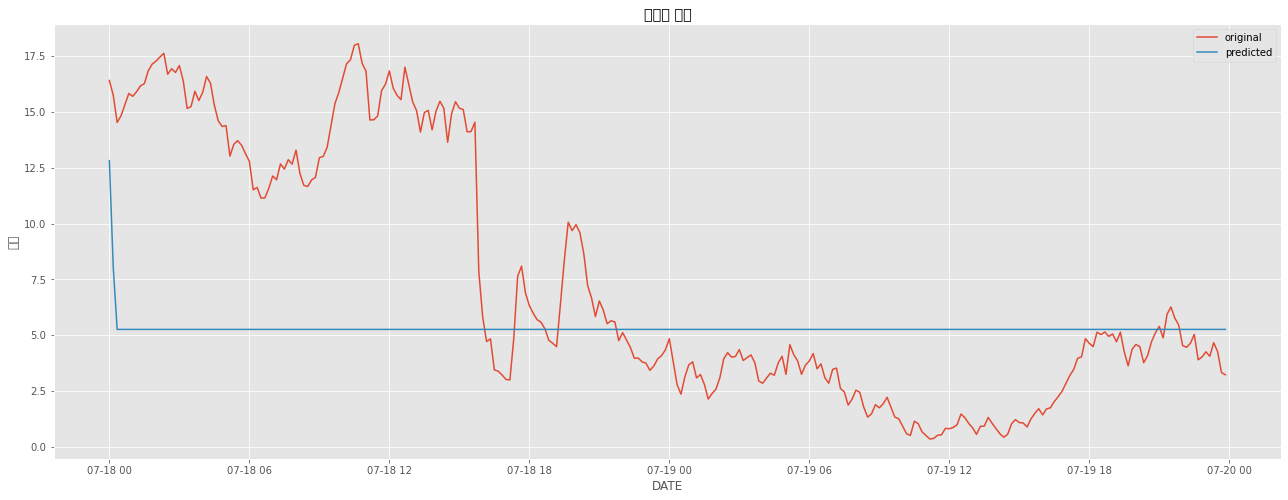

In [135]:
start_index=datetime(2021,7,18,0,0)
end_index=datetime(2021,7,19,23,50)
forecast = model_fit.predict(start=start_index,end=end_index,type='levels')

#시각화
plt.figure(figsize=(22,8))
plt.plot(train_data.loc[start_index:].index,train_data.loc[start_index:].Wspd,label="original")
plt.plot(forecast,label='predicted')
plt.title("시계열 예측")
plt.xlabel("DATE")
plt.ylabel("풍속")
plt.legend()
plt.show()





In [124]:
forecast

2021-07-18 00:00:00    16.759966
2021-07-18 00:10:00    16.476414
2021-07-18 00:20:00    16.188451
2021-07-18 00:30:00    15.909252
2021-07-18 00:40:00    15.637015
                         ...    
2021-07-19 23:10:00     5.261095
2021-07-19 23:20:00     5.260901
2021-07-19 23:30:00     5.260712
2021-07-19 23:40:00     5.260528
2021-07-19 23:50:00     5.260348
Freq: 10T, Name: predicted_mean, Length: 288, dtype: float64